# Exploring Cell Coverage of Routes
* To do later: move data sources to a catalog
* An agency here is defined: as a service and an operator...

In [1]:
# Read in zip files
import fsspec

# Other
import geopandas as gpd
import numpy as np
import pandas as pd
# import shared_utils
from calitp import *

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## California County Borders

In [4]:
ca_gdf = gpd.read_file(
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
)

## Trip Routes 

In [5]:
routes_df = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes.parquet"
)

In [6]:
routes_df["route_type"].value_counts()

3    107417
0      3892
1      1322
2       710
5       514
4       241
Name: route_type, dtype: int64

In [7]:
routes_subset = routes_df[["route_type", "route_name", "agency"]]

In [8]:
cols_without_geometry = [
    "agency",
    "route_name",
    "itp_id",
    "route_id",
    "shape_id",
    "route_type",
]

In [9]:
# Drop Amtrak
routes_df2 = routes_df.loc[routes_df["agency"] != "Amtrak"]

In [10]:
# Filter for only bus routes
routes_df2 = routes_df.loc[routes_df["route_type"] == "3"]

In [11]:
# routes_df2[['agency','route_name']].sample(10)

In [12]:
f"{len(routes_df2)} rows left after dropping - compared to {len(routes_df)} rows before."

'107417 rows left after dropping - compared to 114096 rows before.'

In [13]:
routes_df2['route_id'].nunique()

1730

In [14]:
# Fill in NA for route names and agency names
routes_df2[["agency", "route_name"]] = routes_df2[["agency", "route_name"]].fillna("NA")

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# Keep only one row per route_id
# is there another way I should pick each route?
routes_df3 = routes_df2.drop_duplicates(subset=["route_id"])

In [16]:
# Keep only one instance of a unique ITP ID - route_name combo
routes_df3 = routes_df3.drop_duplicates(subset=["itp_id", "route_name"])

In [17]:
# Reset index after dropping
routes_df3 = routes_df3.reset_index()

In [18]:
f"{routes_df3.route_id.nunique()} unique route ids, {routes_df3.route_name.nunique()} different route names, and {routes_df3.shape_id.nunique()} different shape ids."

'1467 unique route ids, 1415 different route names, and 1447 different shape ids.'

In [19]:
# routes_df3[['agency','route_name', 'route_id']].head(20).sort_values('route_name')

In [20]:
routes_df3.shape

(1467, 8)

### Test with a single route

In [21]:
# Test a single route that goes through 2 counties
# This one goes through San Francisco & Marin.
single_route = routes_df3.loc[routes_df3['route_name'] == 'via Civic Center']

In [22]:
# Reproject
single_route = single_route.to_crs(ca_gdf.crs)

In [23]:
single_route.crs == ca_gdf.crs

True

In [24]:
single_sjoin = gpd.sjoin(single_route, ca_gdf, how = "inner", predicate = "intersects")

In [25]:
single_overlay = single_route.overlay(ca_gdf, how='intersection', keep_geom_type = False)

<AxesSubplot:>

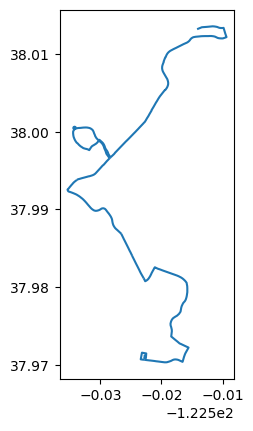

In [26]:
single_overlay.plot()

## FCC AT&T Data Map 
* Testing with AT&T first.

In [27]:
# Open a clipped AT&T map
fcc_ca_gdf = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/AT_T_Data_California_Only.parquet"
)

In [ ]:
# Get rid of columns
fcc_ca_gdf = fcc_ca_gdf.drop(columns = ['DBA', 'Technology', 'MINDOWN', 'MINUP',])

In [28]:
# fcc_ca_gdf.plot(figsize = (30,12))

## Overlay 
* I want to obtain routes that are NOT contained in the AT & T coverage map.
* https://geopandas.org/en/stable/docs/user_guide/set_operations.html
* To obtain the geometries that are part of df1 but are not contained in df2, you can use how='difference'.

In [29]:
# Check that they are the same CRS
fcc_ca_gdf.crs == routes_df3.crs

True

In [31]:
# Testing with intersection per Tiffany's suggestion
overlay_df  = routes_df3.overlay(fcc_ca_gdf, how="intersection", keep_geom_type= "false")

In [32]:
# But difference still shows...how can these 2 things be possible at the same time?
overlay_df_diff= routes_df3.overlay(fcc_ca_gdf, how="difference", keep_geom_type= "false")

In [106]:
# Looking for routes that sit within AT&T borders.
# Keeping inner geometries between the two
# Get rid of routes that don't overlap with any AT&T borders
# https://geopandas.org/en/stable/docs/user_guide/mergingdata.html?highlight=predicate#spatial-joins
sjoin1 = gpd.sjoin(routes_df3, fcc_ca_gdf, how = "inner", predicate = "within")

In [96]:
# Change predicate to intersect
sjoin2 = gpd.sjoin(routes_df3, fcc_ca_gdf, how = "inner", predicate = "intersects")

In [47]:
# Change order: at&t areas that contain routes
# Same as sjoin1?
sjoin3 = gpd.sjoin(fcc_ca_gdf, routes_df3,  how = "inner", predicate = "contains")

In [107]:
sjoin1['route_id'].nunique(),sjoin2['route_id'].nunique(), sjoin3['route_id'].nunique(), 

(1116, 1467, 1116)

In [62]:
routes_test_list = sjoin1['route_id'].unique().tolist()

In [63]:
# Filter out for routes not in list
test = routes_df3[~routes_df3["route_id"].isin(routes_test_list)]

In [65]:
display(
    Markdown(
        f"""There are {overlay_df['route_id'].nunique()} routes (run by {overlay_df['agency'].nunique()} different agencies) 
       that intersects w/ the AT&T coverage map when how = 'intersect'.
       However there are {overlay_df_diff['route_id'].nunique()} routes when 
       setting how to difference. Doing sjoin, there are {len(routes_df3)-len(sjoin1)} routes that don't overlap.
       In comparison, there are {routes_df3.route_id.nunique()} total routes in the original dataframe."""
    )
)

There are 1467 routes (run by 141 different agencies) 
       that intersects w/ the AT&T coverage map when how = 'intersect'.
       However there are 232 routes when 
       setting how to difference. Doing sjoin, there are 351 routes that don't overlap.
       In comparison, there are 1467 total routes in the original dataframe.

In [140]:
# Agencies with the most routes
# test[['agency','route_name', 'route_id']].sort_values('agency')

(<AxesSubplot:>, <AxesSubplot:>)

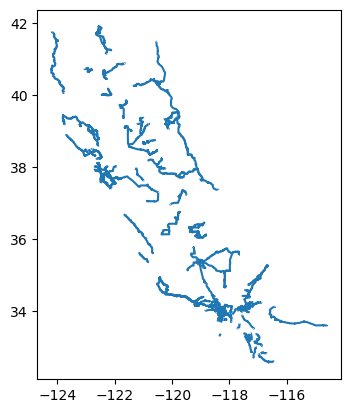

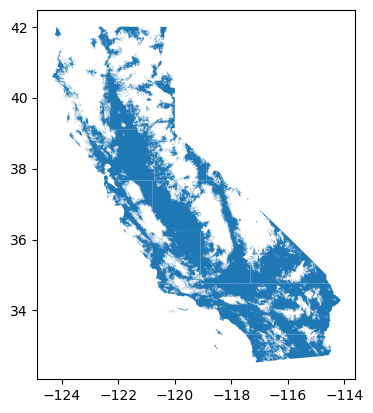

In [109]:
test.plot(), fcc_ca_gdf.plot()

In [110]:
# List for unique itp_ids
agencies_no_coverage = test["itp_id"].unique().tolist()

In [111]:
# List for unique route ids
routes_no_coverage = test["route_id"].unique().tolist()

In [112]:
# List for unique route ids
routes_no_coverage_name = test["route_name"].unique().tolist()

In [113]:
# A table with all the itp id & agencies
agency_df = test[["agency", "itp_id"]].drop_duplicates().reset_index()

## Trips
* How many trips are running for a route?

In [116]:
trips_df = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/trips_2022-05-04_all.parquet"
)

In [117]:
trips_df.shape

(104934, 14)

In [118]:
trips_df.head(1)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_short_name,route_long_name,route_desc,route_type
0,4,0,2022-05-04,1582047897989018365,272020,21,1,shp-21-23,2022-03-26,2099-01-01,21,Dimond - Fruitvale - Bay Farm,None,3


In [119]:
# Add agency name
trips_df = pd.merge(
    trips_df, agency_df, how="inner", left_on="calitp_itp_id", right_on="itp_id"
)

In [120]:
# Try to standardize route id for the 2 dfs
overlay_df["route_id"] = overlay_df["route_id"].str.lower().str.strip()
trips_df["route_id"] = trips_df["route_id"].str.lower().str.strip()

In [121]:
# Filter out for route IDS
trips_df2 = trips_df[trips_df["route_id"].isin(routes_no_coverage)]

In [122]:
# So many route ids disappeared
f'{trips_df2["route_id"].nunique()} routes left after filtering trips_df compared to {len(routes_no_coverage)} routes in overlay.'

'234 routes left after filtering trips_df compared to 351 routes in overlay.'

In [123]:
# Checking which ones are missing.
id_routes = set(routes_no_coverage)
id_trips = set(trips_df2.route_id.unique().tolist())
missing_routes = list(id_routes - id_trips)

In [124]:
f"{len(missing_routes)/len(routes_no_coverage)}% of routes missing"

'0.3333333333333333% of routes missing'

In [125]:
# Sum up number of trips taken by route using trip id?
trips_ran = (
    trips_df2.groupby(["calitp_itp_id", "route_long_name", "agency"])
    .agg({"trip_id": "count"})
    .reset_index()
    .rename(columns={"trip_id": "total_trips"})
)

In [126]:
trips_ran.shape

(327, 4)

In [127]:
# trips_ran

In [128]:
trips_ran["agency"].nunique()

58